In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 3ktwzbr5


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-3ktwzbr5:best, 58.47MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:4.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                    | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                            | 1/1186 [00:00<11:58,  1.65it/s]

  1%|▌                                                                                                           | 6/1186 [00:00<01:51, 10.61it/s]

  1%|▉                                                                                                          | 11/1186 [00:00<01:03, 18.42it/s]

  1%|█▍                                                                                                         | 16/1186 [00:00<00:47, 24.86it/s]

  2%|█▉                                                                                                         | 21/1186 [00:01<00:38, 29.94it/s]

  2%|██▎                                                                                                        | 26/1186 [00:01<00:34, 33.85it/s]

  3%|██▊                                                                                                        | 31/1186 [00:01<00:31, 36.81it/s]

  3%|███▏                                                                                                       | 36/1186 [00:01<00:29, 38.94it/s]

  3%|███▋                                                                                                       | 41/1186 [00:01<00:28, 40.47it/s]

  4%|████▏                                                                                                      | 46/1186 [00:01<00:27, 41.64it/s]

  4%|████▌                                                                                                      | 51/1186 [00:01<00:26, 42.48it/s]

  5%|█████                                                                                                      | 56/1186 [00:01<00:26, 43.10it/s]

  5%|█████▌                                                                                                     | 61/1186 [00:01<00:25, 43.55it/s]

  6%|█████▉                                                                                                     | 66/1186 [00:02<00:25, 43.94it/s]

  6%|██████▍                                                                                                    | 71/1186 [00:02<00:25, 44.15it/s]

  6%|██████▊                                                                                                    | 76/1186 [00:02<00:25, 44.32it/s]

  7%|███████▎                                                                                                   | 81/1186 [00:02<00:24, 44.49it/s]

  7%|███████▊                                                                                                   | 86/1186 [00:02<00:24, 44.49it/s]

  8%|████████▏                                                                                                  | 91/1186 [00:02<00:24, 44.51it/s]

  8%|████████▋                                                                                                  | 96/1186 [00:02<00:24, 44.57it/s]

  9%|█████████                                                                                                 | 101/1186 [00:02<00:24, 44.63it/s]

  9%|█████████▍                                                                                                | 106/1186 [00:02<00:24, 44.63it/s]

  9%|█████████▉                                                                                                | 111/1186 [00:03<00:24, 44.65it/s]

 10%|██████████▎                                                                                               | 116/1186 [00:03<00:23, 44.70it/s]

 10%|██████████▊                                                                                               | 121/1186 [00:03<00:23, 44.69it/s]

 11%|███████████▎                                                                                              | 126/1186 [00:03<00:23, 44.67it/s]

 11%|███████████▋                                                                                              | 131/1186 [00:03<00:23, 44.69it/s]

 11%|████████████▏                                                                                             | 136/1186 [00:03<00:23, 44.78it/s]

 12%|████████████▌                                                                                             | 141/1186 [00:03<00:23, 44.77it/s]

 12%|█████████████                                                                                             | 146/1186 [00:03<00:23, 44.76it/s]

 13%|█████████████▍                                                                                            | 151/1186 [00:03<00:23, 44.82it/s]

 13%|█████████████▉                                                                                            | 156/1186 [00:04<00:22, 44.80it/s]

 14%|██████████████▍                                                                                           | 161/1186 [00:04<00:22, 44.79it/s]

 14%|██████████████▊                                                                                           | 166/1186 [00:04<00:22, 44.78it/s]

 14%|███████████████▎                                                                                          | 171/1186 [00:04<00:22, 44.83it/s]

 15%|███████████████▋                                                                                          | 176/1186 [00:04<00:22, 44.73it/s]

 15%|████████████████▏                                                                                         | 181/1186 [00:04<00:22, 44.64it/s]

 16%|████████████████▌                                                                                         | 186/1186 [00:04<00:22, 44.65it/s]

 16%|█████████████████                                                                                         | 191/1186 [00:04<00:22, 44.52it/s]

 17%|█████████████████▌                                                                                        | 196/1186 [00:04<00:22, 44.41it/s]

 17%|█████████████████▉                                                                                        | 201/1186 [00:05<00:22, 44.38it/s]

 17%|██████████████████▍                                                                                       | 206/1186 [00:05<00:22, 44.37it/s]

 18%|██████████████████▊                                                                                       | 211/1186 [00:05<00:21, 44.32it/s]

 18%|███████████████████▎                                                                                      | 216/1186 [00:05<00:21, 44.30it/s]

 19%|███████████████████▊                                                                                      | 221/1186 [00:05<00:21, 44.32it/s]

 19%|████████████████████▏                                                                                     | 226/1186 [00:05<00:21, 44.28it/s]

 19%|████████████████████▋                                                                                     | 231/1186 [00:05<00:21, 44.25it/s]

 20%|█████████████████████                                                                                     | 236/1186 [00:05<00:21, 44.23it/s]

 20%|█████████████████████▌                                                                                    | 241/1186 [00:05<00:21, 44.26it/s]

 21%|█████████████████████▉                                                                                    | 246/1186 [00:06<00:21, 44.24it/s]

 21%|██████████████████████▍                                                                                   | 251/1186 [00:06<00:21, 44.22it/s]

 22%|██████████████████████▉                                                                                   | 256/1186 [00:06<00:21, 44.23it/s]

 22%|███████████████████████▎                                                                                  | 261/1186 [00:06<00:20, 44.38it/s]

 22%|███████████████████████▊                                                                                  | 266/1186 [00:06<00:20, 44.57it/s]

 23%|████████████████████████▏                                                                                 | 271/1186 [00:06<00:20, 44.63it/s]

 23%|████████████████████████▋                                                                                 | 276/1186 [00:06<00:20, 44.59it/s]

 24%|█████████████████████████                                                                                 | 281/1186 [00:06<00:20, 44.52it/s]

 24%|█████████████████████████▌                                                                                | 286/1186 [00:07<00:20, 44.55it/s]

 25%|██████████████████████████                                                                                | 291/1186 [00:07<00:20, 44.51it/s]

 25%|██████████████████████████▍                                                                               | 296/1186 [00:07<00:20, 44.49it/s]

 25%|██████████████████████████▉                                                                               | 301/1186 [00:07<00:19, 44.54it/s]

 26%|███████████████████████████▎                                                                              | 306/1186 [00:07<00:19, 44.42it/s]

 26%|███████████████████████████▊                                                                              | 311/1186 [00:07<00:19, 44.41it/s]

 27%|████████████████████████████▏                                                                             | 316/1186 [00:07<00:19, 44.39it/s]

 27%|████████████████████████████▋                                                                             | 321/1186 [00:07<00:19, 44.48it/s]

 27%|█████████████████████████████▏                                                                            | 326/1186 [00:07<00:19, 44.56it/s]

 28%|█████████████████████████████▌                                                                            | 331/1186 [00:08<00:19, 44.62it/s]

 28%|██████████████████████████████                                                                            | 336/1186 [00:08<00:19, 44.68it/s]

 29%|██████████████████████████████▍                                                                           | 341/1186 [00:08<00:18, 44.79it/s]

 29%|██████████████████████████████▉                                                                           | 346/1186 [00:08<00:18, 44.78it/s]

 30%|███████████████████████████████▎                                                                          | 351/1186 [00:08<00:18, 44.77it/s]

 30%|███████████████████████████████▊                                                                          | 356/1186 [00:08<00:18, 44.84it/s]

 30%|████████████████████████████████▎                                                                         | 361/1186 [00:08<00:18, 44.80it/s]

 31%|████████████████████████████████▋                                                                         | 366/1186 [00:08<00:18, 44.79it/s]

 31%|█████████████████████████████████▏                                                                        | 371/1186 [00:08<00:18, 44.78it/s]

 32%|█████████████████████████████████▌                                                                        | 376/1186 [00:09<00:18, 44.82it/s]

 32%|██████████████████████████████████                                                                        | 381/1186 [00:09<00:17, 44.81it/s]

 33%|██████████████████████████████████▍                                                                       | 386/1186 [00:09<00:17, 44.79it/s]

 33%|██████████████████████████████████▉                                                                       | 391/1186 [00:09<00:17, 44.80it/s]

 33%|███████████████████████████████████▍                                                                      | 396/1186 [00:09<00:17, 44.87it/s]

 34%|███████████████████████████████████▊                                                                      | 401/1186 [00:09<00:17, 44.84it/s]

 34%|████████████████████████████████████▎                                                                     | 406/1186 [00:09<00:17, 44.81it/s]

 35%|████████████████████████████████████▋                                                                     | 411/1186 [00:09<00:17, 44.81it/s]

 35%|█████████████████████████████████████▏                                                                    | 416/1186 [00:09<00:17, 44.87it/s]

 35%|█████████████████████████████████████▋                                                                    | 421/1186 [00:10<00:17, 44.83it/s]

 36%|██████████████████████████████████████                                                                    | 426/1186 [00:10<00:16, 44.79it/s]

 36%|██████████████████████████████████████▌                                                                   | 431/1186 [00:10<00:16, 44.80it/s]

 37%|██████████████████████████████████████▉                                                                   | 436/1186 [00:10<00:16, 44.80it/s]

 37%|███████████████████████████████████████▍                                                                  | 441/1186 [00:10<00:16, 44.80it/s]

 38%|███████████████████████████████████████▊                                                                  | 446/1186 [00:10<00:16, 44.80it/s]

 38%|████████████████████████████████████████▎                                                                 | 451/1186 [00:10<00:16, 44.84it/s]

 38%|████████████████████████████████████████▊                                                                 | 456/1186 [00:10<00:16, 44.71it/s]

 39%|█████████████████████████████████████████▏                                                                | 461/1186 [00:10<00:16, 44.81it/s]

 39%|█████████████████████████████████████████▋                                                                | 466/1186 [00:11<00:16, 44.82it/s]

 40%|██████████████████████████████████████████                                                                | 471/1186 [00:11<00:15, 44.88it/s]

 40%|██████████████████████████████████████████▌                                                               | 476/1186 [00:11<00:15, 44.85it/s]

 41%|██████████████████████████████████████████▉                                                               | 481/1186 [00:11<00:15, 44.84it/s]

 41%|███████████████████████████████████████████▍                                                              | 486/1186 [00:11<00:15, 44.88it/s]

 41%|███████████████████████████████████████████▉                                                              | 491/1186 [00:11<00:15, 44.85it/s]

 42%|████████████████████████████████████████████▎                                                             | 496/1186 [00:11<00:15, 44.83it/s]

 42%|████████████████████████████████████████████▊                                                             | 501/1186 [00:11<00:15, 44.80it/s]

 43%|█████████████████████████████████████████████▏                                                            | 506/1186 [00:11<00:15, 44.81it/s]

 43%|█████████████████████████████████████████████▋                                                            | 511/1186 [00:12<00:15, 44.71it/s]

 44%|██████████████████████████████████████████████                                                            | 516/1186 [00:12<00:15, 44.48it/s]

 44%|██████████████████████████████████████████████▌                                                           | 521/1186 [00:12<00:14, 44.56it/s]

 44%|███████████████████████████████████████████████                                                           | 526/1186 [00:12<00:14, 44.69it/s]

 45%|███████████████████████████████████████████████▍                                                          | 531/1186 [00:12<00:14, 44.71it/s]

 45%|███████████████████████████████████████████████▉                                                          | 536/1186 [00:12<00:14, 44.68it/s]

 46%|████████████████████████████████████████████████▎                                                         | 541/1186 [00:12<00:14, 44.67it/s]

 46%|████████████████████████████████████████████████▊                                                         | 546/1186 [00:12<00:14, 44.73it/s]

 46%|█████████████████████████████████████████████████▏                                                        | 551/1186 [00:12<00:14, 44.71it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 556/1186 [00:13<00:14, 44.73it/s]

 47%|██████████████████████████████████████████████████▏                                                       | 561/1186 [00:13<00:13, 44.80it/s]

 48%|██████████████████████████████████████████████████▌                                                       | 566/1186 [00:13<00:13, 44.78it/s]

 48%|███████████████████████████████████████████████████                                                       | 571/1186 [00:13<00:13, 44.78it/s]

 49%|███████████████████████████████████████████████████▍                                                      | 576/1186 [00:13<00:13, 44.76it/s]

 49%|███████████████████████████████████████████████████▉                                                      | 581/1186 [00:13<00:13, 44.75it/s]

 49%|████████████████████████████████████████████████████▎                                                     | 586/1186 [00:13<00:13, 44.72it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 591/1186 [00:13<00:13, 44.70it/s]

 50%|█████████████████████████████████████████████████████▎                                                    | 596/1186 [00:13<00:13, 44.72it/s]

 51%|█████████████████████████████████████████████████████▋                                                    | 601/1186 [00:14<00:13, 44.70it/s]

 51%|██████████████████████████████████████████████████████▏                                                   | 606/1186 [00:14<00:13, 44.57it/s]

 52%|██████████████████████████████████████████████████████▌                                                   | 611/1186 [00:14<00:12, 44.48it/s]

 52%|███████████████████████████████████████████████████████                                                   | 616/1186 [00:14<00:12, 44.42it/s]

 52%|███████████████████████████████████████████████████████▌                                                  | 621/1186 [00:14<00:12, 44.42it/s]

 53%|███████████████████████████████████████████████████████▉                                                  | 626/1186 [00:14<00:12, 44.36it/s]

 53%|████████████████████████████████████████████████████████▍                                                 | 631/1186 [00:14<00:12, 44.33it/s]

 54%|████████████████████████████████████████████████████████▊                                                 | 636/1186 [00:14<00:12, 44.38it/s]

 54%|█████████████████████████████████████████████████████████▎                                                | 641/1186 [00:14<00:12, 44.33it/s]

 54%|█████████████████████████████████████████████████████████▋                                                | 646/1186 [00:15<00:12, 44.27it/s]

 55%|██████████████████████████████████████████████████████████▏                                               | 651/1186 [00:15<00:12, 44.26it/s]

 55%|██████████████████████████████████████████████████████████▋                                               | 656/1186 [00:15<00:11, 44.34it/s]

 56%|███████████████████████████████████████████████████████████                                               | 661/1186 [00:15<00:11, 44.30it/s]

 56%|███████████████████████████████████████████████████████████▌                                              | 666/1186 [00:15<00:11, 44.28it/s]

 57%|███████████████████████████████████████████████████████████▉                                              | 671/1186 [00:15<00:11, 44.29it/s]

 57%|████████████████████████████████████████████████████████████▍                                             | 676/1186 [00:15<00:11, 44.33it/s]

 57%|████████████████████████████████████████████████████████████▊                                             | 681/1186 [00:15<00:11, 44.29it/s]

 58%|█████████████████████████████████████████████████████████████▎                                            | 686/1186 [00:15<00:11, 44.28it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 691/1186 [00:16<00:11, 44.33it/s]

 59%|██████████████████████████████████████████████████████████████▏                                           | 696/1186 [00:16<00:11, 44.30it/s]

 59%|██████████████████████████████████████████████████████████████▋                                           | 701/1186 [00:16<00:10, 44.29it/s]

 60%|███████████████████████████████████████████████████████████████                                           | 706/1186 [00:16<00:10, 44.29it/s]

 60%|███████████████████████████████████████████████████████████████▌                                          | 711/1186 [00:16<00:10, 44.33it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 716/1186 [00:16<00:10, 44.30it/s]

 61%|████████████████████████████████████████████████████████████████▍                                         | 721/1186 [00:16<00:10, 44.29it/s]

 61%|████████████████████████████████████████████████████████████████▉                                         | 726/1186 [00:16<00:10, 44.33it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                        | 731/1186 [00:16<00:10, 44.20it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                        | 736/1186 [00:17<00:10, 44.28it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                       | 741/1186 [00:17<00:10, 44.23it/s]

 63%|██████████████████████████████████████████████████████████████████▋                                       | 746/1186 [00:17<00:09, 44.20it/s]

 63%|███████████████████████████████████████████████████████████████████                                       | 751/1186 [00:17<00:09, 44.29it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                      | 756/1186 [00:17<00:09, 44.26it/s]

 64%|████████████████████████████████████████████████████████████████████                                      | 761/1186 [00:17<00:09, 44.26it/s]

 65%|████████████████████████████████████████████████████████████████████▍                                     | 766/1186 [00:17<00:09, 44.28it/s]

 65%|████████████████████████████████████████████████████████████████████▉                                     | 771/1186 [00:17<00:09, 44.47it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                    | 776/1186 [00:17<00:09, 44.56it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                    | 781/1186 [00:18<00:09, 44.63it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                   | 786/1186 [00:18<00:08, 44.74it/s]

 67%|██████████████████████████████████████████████████████████████████████▋                                   | 791/1186 [00:18<00:08, 44.75it/s]

 67%|███████████████████████████████████████████████████████████████████████▏                                  | 796/1186 [00:18<00:08, 44.76it/s]

 68%|███████████████████████████████████████████████████████████████████████▌                                  | 801/1186 [00:18<00:08, 44.78it/s]

 68%|████████████████████████████████████████████████████████████████████████                                  | 806/1186 [00:18<00:08, 44.69it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                 | 811/1186 [00:18<00:08, 44.72it/s]

 69%|████████████████████████████████████████████████████████████████████████▉                                 | 816/1186 [00:18<00:08, 44.74it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                | 821/1186 [00:19<00:08, 44.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████▊                                | 826/1186 [00:19<00:08, 44.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▎                               | 831/1186 [00:19<00:07, 44.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                               | 836/1186 [00:19<00:07, 44.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████▏                              | 841/1186 [00:19<00:07, 44.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                              | 846/1186 [00:19<00:07, 44.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████                              | 851/1186 [00:19<00:07, 44.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                             | 856/1186 [00:19<00:07, 44.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                             | 861/1186 [00:19<00:07, 44.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▍                            | 866/1186 [00:20<00:07, 44.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                            | 871/1186 [00:20<00:07, 44.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▎                           | 876/1186 [00:20<00:06, 44.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 881/1186 [00:20<00:06, 44.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                          | 886/1186 [00:20<00:06, 44.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▋                          | 891/1186 [00:20<00:06, 44.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                          | 896/1186 [00:20<00:06, 44.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 901/1186 [00:20<00:06, 44.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                         | 906/1186 [00:20<00:06, 44.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▍                        | 911/1186 [00:21<00:06, 44.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 916/1186 [00:21<00:06, 44.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 921/1186 [00:21<00:05, 44.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 926/1186 [00:21<00:05, 44.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                      | 931/1186 [00:21<00:05, 44.31it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 936/1186 [00:21<00:05, 44.22it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                      | 941/1186 [00:21<00:05, 44.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 946/1186 [00:21<00:05, 44.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 951/1186 [00:21<00:05, 44.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 956/1186 [00:22<00:05, 44.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 961/1186 [00:22<00:05, 44.01it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 966/1186 [00:22<00:04, 44.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▊                   | 971/1186 [00:22<00:04, 43.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 976/1186 [00:22<00:04, 43.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 981/1186 [00:22<00:04, 43.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████                  | 986/1186 [00:22<00:04, 43.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 991/1186 [00:22<00:04, 43.99it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 996/1186 [00:22<00:04, 43.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 1001/1186 [00:23<00:04, 43.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 1006/1186 [00:23<00:04, 43.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 1011/1186 [00:23<00:03, 44.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 1016/1186 [00:23<00:03, 43.99it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 1021/1186 [00:23<00:03, 43.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 1026/1186 [00:23<00:03, 43.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 1031/1186 [00:23<00:03, 43.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 1036/1186 [00:23<00:03, 43.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 1041/1186 [00:23<00:03, 44.07it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 1046/1186 [00:24<00:03, 44.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 1051/1186 [00:24<00:03, 44.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▍           | 1056/1186 [00:24<00:02, 44.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 1061/1186 [00:24<00:02, 44.00it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 1066/1186 [00:24<00:02, 43.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 1071/1186 [00:24<00:02, 43.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 1076/1186 [00:24<00:02, 43.97it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 1081/1186 [00:24<00:02, 43.92it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1086/1186 [00:24<00:02, 43.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1091/1186 [00:25<00:02, 43.73it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 1096/1186 [00:25<00:02, 43.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1101/1186 [00:25<00:01, 43.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1106/1186 [00:25<00:01, 43.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1111/1186 [00:25<00:01, 43.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1116/1186 [00:25<00:01, 43.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1121/1186 [00:25<00:01, 43.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1126/1186 [00:25<00:01, 43.74it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1131/1186 [00:26<00:01, 43.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1136/1186 [00:26<00:01, 43.66it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 1141/1186 [00:26<00:01, 43.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1146/1186 [00:26<00:00, 43.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1151/1186 [00:26<00:00, 43.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1156/1186 [00:26<00:00, 43.48it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1161/1186 [00:26<00:00, 43.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1166/1186 [00:26<00:00, 43.51it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1171/1186 [00:26<00:00, 43.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1176/1186 [00:27<00:00, 43.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1181/1186 [00:27<00:00, 43.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:27<00:00, 41.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:27<00:00, 43.40it/s]

train - OK


  0%|                                                                                                                     | 0/297 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/297 [00:00<01:08,  4.32it/s]

  2%|██▏                                                                                                          | 6/297 [00:00<00:14, 20.58it/s]

  4%|████                                                                                                        | 11/297 [00:00<00:09, 29.07it/s]

  5%|█████▊                                                                                                      | 16/297 [00:00<00:08, 34.01it/s]

  7%|███████▋                                                                                                    | 21/297 [00:00<00:07, 37.08it/s]

  9%|█████████▍                                                                                                  | 26/297 [00:00<00:06, 39.06it/s]

 10%|███████████▎                                                                                                | 31/297 [00:00<00:06, 40.37it/s]

 12%|█████████████                                                                                               | 36/297 [00:01<00:06, 41.25it/s]

 14%|██████████████▉                                                                                             | 41/297 [00:01<00:06, 41.85it/s]

 15%|████████████████▋                                                                                           | 46/297 [00:01<00:05, 42.28it/s]

 17%|██████████████████▌                                                                                         | 51/297 [00:01<00:05, 42.58it/s]

 19%|████████████████████▎                                                                                       | 56/297 [00:01<00:05, 42.77it/s]

 21%|██████████████████████▏                                                                                     | 61/297 [00:01<00:05, 42.92it/s]

 22%|████████████████████████                                                                                    | 66/297 [00:01<00:05, 43.01it/s]

 24%|█████████████████████████▊                                                                                  | 71/297 [00:01<00:05, 43.07it/s]

 26%|███████████████████████████▋                                                                                | 76/297 [00:01<00:05, 43.12it/s]

 27%|█████████████████████████████▍                                                                              | 81/297 [00:02<00:05, 43.16it/s]

 29%|███████████████████████████████▎                                                                            | 86/297 [00:02<00:04, 43.18it/s]

 31%|█████████████████████████████████                                                                           | 91/297 [00:02<00:04, 43.22it/s]

 32%|██████████████████████████████████▉                                                                         | 96/297 [00:02<00:04, 43.22it/s]

 34%|████████████████████████████████████▍                                                                      | 101/297 [00:02<00:04, 43.15it/s]

 36%|██████████████████████████████████████▏                                                                    | 106/297 [00:02<00:04, 43.16it/s]

 37%|███████████████████████████████████████▉                                                                   | 111/297 [00:02<00:04, 43.17it/s]

 39%|█████████████████████████████████████████▊                                                                 | 116/297 [00:02<00:04, 43.20it/s]

 41%|███████████████████████████████████████████▌                                                               | 121/297 [00:03<00:04, 43.18it/s]

 42%|█████████████████████████████████████████████▍                                                             | 126/297 [00:03<00:03, 43.20it/s]

 44%|███████████████████████████████████████████████▏                                                           | 131/297 [00:03<00:03, 43.21it/s]

 46%|████████████████████████████████████████████████▉                                                          | 136/297 [00:03<00:03, 43.21it/s]

 47%|██████████████████████████████████████████████████▊                                                        | 141/297 [00:03<00:03, 43.21it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 146/297 [00:03<00:03, 43.22it/s]

 51%|██████████████████████████████████████████████████████▍                                                    | 151/297 [00:03<00:03, 43.22it/s]

 53%|████████████████████████████████████████████████████████▏                                                  | 156/297 [00:03<00:03, 43.19it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 161/297 [00:03<00:03, 43.20it/s]

 56%|███████████████████████████████████████████████████████████▊                                               | 166/297 [00:04<00:03, 43.22it/s]

 58%|█████████████████████████████████████████████████████████████▌                                             | 171/297 [00:04<00:02, 43.22it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 176/297 [00:04<00:02, 43.19it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 181/297 [00:04<00:02, 43.20it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 186/297 [00:04<00:02, 43.24it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 191/297 [00:04<00:02, 43.41it/s]

 66%|██████████████████████████████████████████████████████████████████████▌                                    | 196/297 [00:04<00:02, 43.47it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 201/297 [00:04<00:02, 43.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                | 206/297 [00:04<00:02, 43.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 211/297 [00:05<00:01, 43.61it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 216/297 [00:05<00:01, 43.67it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 221/297 [00:05<00:01, 43.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 226/297 [00:05<00:01, 43.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 231/297 [00:05<00:01, 43.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                      | 236/297 [00:05<00:01, 43.64it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 241/297 [00:05<00:01, 43.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 246/297 [00:05<00:01, 43.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 251/297 [00:05<00:01, 43.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 256/297 [00:06<00:00, 43.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 261/297 [00:06<00:00, 43.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 266/297 [00:06<00:00, 43.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 271/297 [00:06<00:00, 43.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 276/297 [00:06<00:00, 43.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 281/297 [00:06<00:00, 43.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 286/297 [00:06<00:00, 43.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 291/297 [00:06<00:00, 43.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 296/297 [00:07<00:00, 43.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:07<00:00, 41.44it/s]

val - OK


  0%|                                                                                                                     | 0/437 [00:00<?, ?it/s]

  0%|▏                                                                                                            | 1/437 [00:00<02:00,  3.63it/s]

  1%|█▍                                                                                                           | 6/437 [00:00<00:23, 18.47it/s]

  3%|██▋                                                                                                         | 11/437 [00:00<00:15, 27.18it/s]

  4%|███▉                                                                                                        | 16/437 [00:00<00:12, 32.59it/s]

  5%|█████▏                                                                                                      | 21/437 [00:00<00:11, 36.14it/s]

  6%|██████▍                                                                                                     | 26/437 [00:00<00:10, 38.46it/s]

  7%|███████▋                                                                                                    | 31/437 [00:00<00:10, 40.05it/s]

  8%|████████▉                                                                                                   | 36/437 [00:01<00:09, 41.13it/s]

  9%|██████████▏                                                                                                 | 41/437 [00:01<00:09, 41.89it/s]

 11%|███████████▎                                                                                                | 46/437 [00:01<00:09, 42.38it/s]

 12%|████████████▌                                                                                               | 51/437 [00:01<00:09, 42.74it/s]

 13%|█████████████▊                                                                                              | 56/437 [00:01<00:08, 42.99it/s]

 14%|███████████████                                                                                             | 61/437 [00:01<00:08, 43.17it/s]

 15%|████████████████▎                                                                                           | 66/437 [00:01<00:08, 43.29it/s]

 16%|█████████████████▌                                                                                          | 71/437 [00:01<00:08, 43.39it/s]

 17%|██████████████████▊                                                                                         | 76/437 [00:01<00:08, 43.44it/s]

 19%|████████████████████                                                                                        | 81/437 [00:02<00:08, 43.49it/s]

 20%|█████████████████████▎                                                                                      | 86/437 [00:02<00:08, 43.47it/s]

 21%|██████████████████████▍                                                                                     | 91/437 [00:02<00:07, 43.37it/s]

 22%|███████████████████████▋                                                                                    | 96/437 [00:02<00:07, 43.28it/s]

 23%|████████████████████████▋                                                                                  | 101/437 [00:02<00:07, 43.25it/s]

 24%|█████████████████████████▉                                                                                 | 106/437 [00:02<00:07, 43.26it/s]

 25%|███████████████████████████▏                                                                               | 111/437 [00:02<00:07, 43.24it/s]

 27%|████████████████████████████▍                                                                              | 116/437 [00:02<00:07, 43.26it/s]

 28%|█████████████████████████████▋                                                                             | 121/437 [00:03<00:07, 43.23it/s]

 29%|██████████████████████████████▊                                                                            | 126/437 [00:03<00:07, 43.21it/s]

 30%|████████████████████████████████                                                                           | 131/437 [00:03<00:07, 43.20it/s]

 31%|█████████████████████████████████▎                                                                         | 136/437 [00:03<00:06, 43.24it/s]

 32%|██████████████████████████████████▌                                                                        | 141/437 [00:03<00:06, 43.27it/s]

 33%|███████████████████████████████████▋                                                                       | 146/437 [00:03<00:06, 43.30it/s]

 35%|████████████████████████████████████▉                                                                      | 151/437 [00:03<00:06, 43.31it/s]

 36%|██████████████████████████████████████▏                                                                    | 156/437 [00:03<00:06, 43.31it/s]

 37%|███████████████████████████████████████▍                                                                   | 161/437 [00:03<00:06, 43.34it/s]

 38%|████████████████████████████████████████▋                                                                  | 166/437 [00:04<00:06, 43.38it/s]

 39%|█████████████████████████████████████████▊                                                                 | 171/437 [00:04<00:06, 43.39it/s]

 40%|███████████████████████████████████████████                                                                | 176/437 [00:04<00:06, 43.34it/s]

 41%|████████████████████████████████████████████▎                                                              | 181/437 [00:04<00:05, 43.36it/s]

 43%|█████████████████████████████████████████████▌                                                             | 186/437 [00:04<00:05, 43.35it/s]

 44%|██████████████████████████████████████████████▊                                                            | 191/437 [00:04<00:05, 43.37it/s]

 45%|███████████████████████████████████████████████▉                                                           | 196/437 [00:04<00:05, 43.26it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 201/437 [00:04<00:05, 43.23it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 206/437 [00:05<00:05, 43.23it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 211/437 [00:05<00:05, 43.27it/s]

 49%|████████████████████████████████████████████████████▉                                                      | 216/437 [00:05<00:05, 43.30it/s]

 51%|██████████████████████████████████████████████████████                                                     | 221/437 [00:05<00:04, 43.26it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 226/437 [00:05<00:04, 43.31it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 231/437 [00:05<00:04, 43.33it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 236/437 [00:05<00:04, 43.35it/s]

 55%|███████████████████████████████████████████████████████████                                                | 241/437 [00:05<00:04, 43.31it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 246/437 [00:05<00:04, 43.32it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 251/437 [00:06<00:04, 43.25it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 256/437 [00:06<00:04, 43.24it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 261/437 [00:06<00:04, 43.23it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 266/437 [00:06<00:03, 43.22it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 271/437 [00:06<00:03, 43.22it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 276/437 [00:06<00:03, 43.22it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 281/437 [00:06<00:03, 43.16it/s]

 65%|██████████████████████████████████████████████████████████████████████                                     | 286/437 [00:06<00:03, 43.18it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 291/437 [00:06<00:03, 43.18it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 296/437 [00:07<00:03, 43.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 301/437 [00:07<00:03, 43.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 306/437 [00:07<00:03, 43.18it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 311/437 [00:07<00:02, 43.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 316/437 [00:07<00:02, 43.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 321/437 [00:07<00:02, 43.28it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 326/437 [00:07<00:02, 43.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 331/437 [00:07<00:02, 43.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 336/437 [00:08<00:02, 43.39it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 341/437 [00:08<00:02, 43.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 346/437 [00:08<00:02, 43.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 351/437 [00:08<00:01, 43.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 356/437 [00:08<00:01, 43.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 361/437 [00:08<00:01, 43.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 366/437 [00:08<00:01, 43.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 371/437 [00:08<00:01, 43.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 376/437 [00:08<00:01, 43.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 381/437 [00:09<00:01, 43.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 386/437 [00:09<00:01, 43.40it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 391/437 [00:09<00:01, 43.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 396/437 [00:09<00:00, 43.37it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 401/437 [00:09<00:00, 43.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 406/437 [00:09<00:00, 43.32it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 411/437 [00:09<00:00, 43.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 416/437 [00:09<00:00, 43.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 421/437 [00:09<00:00, 43.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 426/437 [00:10<00:00, 43.42it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 431/437 [00:10<00:00, 43.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 436/437 [00:10<00:00, 43.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 41.75it/s]

test InD - OK


  0%|                                                                                                                     | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/328 [00:00<01:48,  3.02it/s]

  2%|█▉                                                                                                           | 6/328 [00:00<00:19, 16.37it/s]

  3%|███▌                                                                                                        | 11/328 [00:00<00:12, 25.07it/s]

  5%|█████▎                                                                                                      | 16/328 [00:00<00:10, 30.87it/s]

  6%|██████▉                                                                                                     | 21/328 [00:00<00:08, 34.74it/s]

  8%|████████▌                                                                                                   | 26/328 [00:00<00:08, 37.37it/s]

  9%|██████████▏                                                                                                 | 31/328 [00:01<00:07, 39.20it/s]

 11%|███████████▊                                                                                                | 36/328 [00:01<00:07, 40.43it/s]

 12%|█████████████▌                                                                                              | 41/328 [00:01<00:06, 41.34it/s]

 14%|███████████████▏                                                                                            | 46/328 [00:01<00:06, 41.96it/s]

 16%|████████████████▊                                                                                           | 51/328 [00:01<00:06, 42.37it/s]

 17%|██████████████████▍                                                                                         | 56/328 [00:01<00:06, 42.65it/s]

 19%|████████████████████                                                                                        | 61/328 [00:01<00:06, 42.85it/s]

 20%|█████████████████████▋                                                                                      | 66/328 [00:01<00:06, 43.01it/s]

 22%|███████████████████████▍                                                                                    | 71/328 [00:01<00:05, 43.10it/s]

 23%|█████████████████████████                                                                                   | 76/328 [00:02<00:05, 43.17it/s]

 25%|██████████████████████████▋                                                                                 | 81/328 [00:02<00:05, 43.23it/s]

 26%|████████████████████████████▎                                                                               | 86/328 [00:02<00:05, 43.25it/s]

 28%|█████████████████████████████▉                                                                              | 91/328 [00:02<00:05, 43.27it/s]

 29%|███████████████████████████████▌                                                                            | 96/328 [00:02<00:05, 43.29it/s]

 31%|████████████████████████████████▉                                                                          | 101/328 [00:02<00:05, 43.32it/s]

 32%|██████████████████████████████████▌                                                                        | 106/328 [00:02<00:05, 43.30it/s]

 34%|████████████████████████████████████▏                                                                      | 111/328 [00:02<00:05, 43.32it/s]

 35%|█████████████████████████████████████▊                                                                     | 116/328 [00:02<00:04, 43.31it/s]

 37%|███████████████████████████████████████▍                                                                   | 121/328 [00:03<00:04, 43.29it/s]

 38%|█████████████████████████████████████████                                                                  | 126/328 [00:03<00:04, 43.29it/s]

 40%|██████████████████████████████████████████▋                                                                | 131/328 [00:03<00:04, 43.30it/s]

 41%|████████████████████████████████████████████▎                                                              | 136/328 [00:03<00:04, 43.34it/s]

 43%|█████████████████████████████████████████████▉                                                             | 141/328 [00:03<00:04, 43.40it/s]

 45%|███████████████████████████████████████████████▋                                                           | 146/328 [00:03<00:04, 43.43it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 151/328 [00:03<00:04, 43.43it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 156/328 [00:03<00:03, 43.41it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 161/328 [00:04<00:03, 43.43it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 166/328 [00:04<00:03, 43.43it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 171/328 [00:04<00:03, 43.45it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 176/328 [00:04<00:03, 43.39it/s]

 55%|███████████████████████████████████████████████████████████                                                | 181/328 [00:04<00:03, 43.45it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 186/328 [00:04<00:03, 43.47it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 191/328 [00:04<00:03, 43.50it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 196/328 [00:04<00:03, 43.45it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 201/328 [00:04<00:02, 43.47it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 206/328 [00:05<00:02, 43.45it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 211/328 [00:05<00:02, 43.43it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 216/328 [00:05<00:02, 43.40it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 221/328 [00:05<00:02, 43.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 226/328 [00:05<00:02, 43.22it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 231/328 [00:05<00:02, 43.12it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 236/328 [00:05<00:02, 43.07it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 241/328 [00:05<00:02, 43.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 246/328 [00:05<00:01, 43.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 251/328 [00:06<00:01, 43.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 256/328 [00:06<00:01, 43.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 261/328 [00:06<00:01, 43.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 266/328 [00:06<00:01, 43.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 271/328 [00:06<00:01, 43.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 276/328 [00:06<00:01, 43.12it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 281/328 [00:06<00:01, 43.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 286/328 [00:06<00:00, 43.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 291/328 [00:07<00:00, 43.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 296/328 [00:07<00:00, 43.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 301/328 [00:07<00:00, 43.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 306/328 [00:07<00:00, 43.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 311/328 [00:07<00:00, 43.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 316/328 [00:07<00:00, 43.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 321/328 [00:07<00:00, 43.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 326/328 [00:07<00:00, 43.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:08<00:00, 40.79it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)


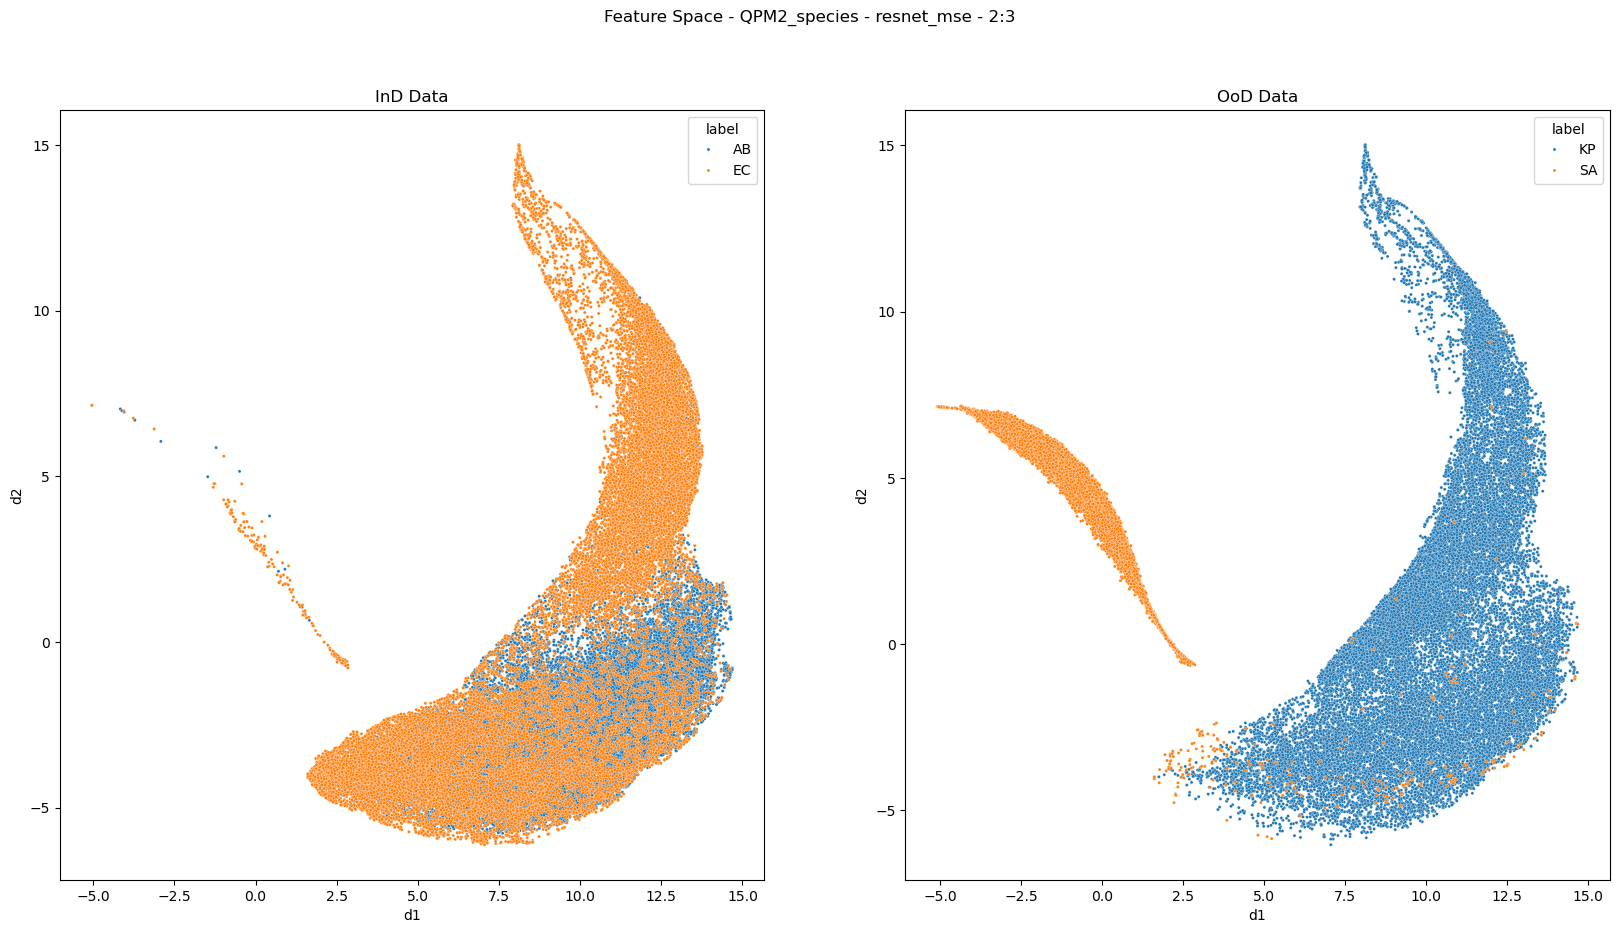

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

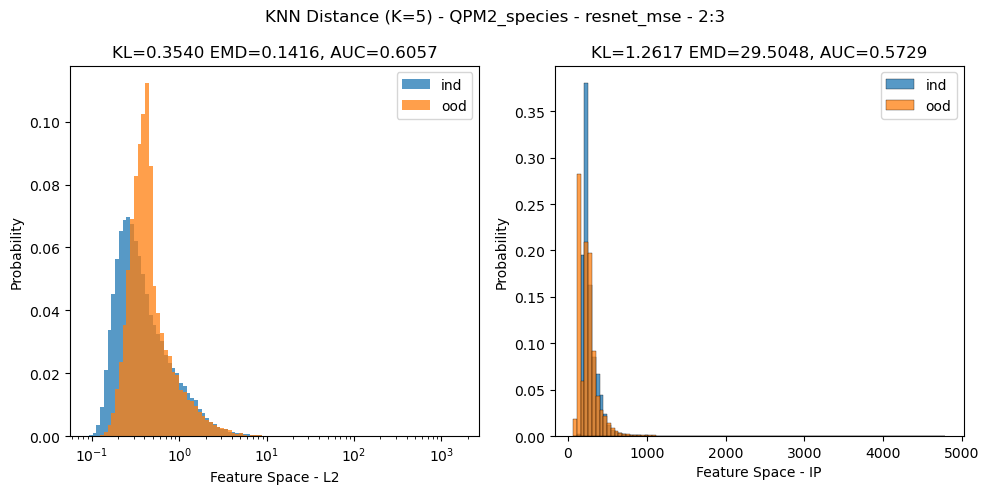

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

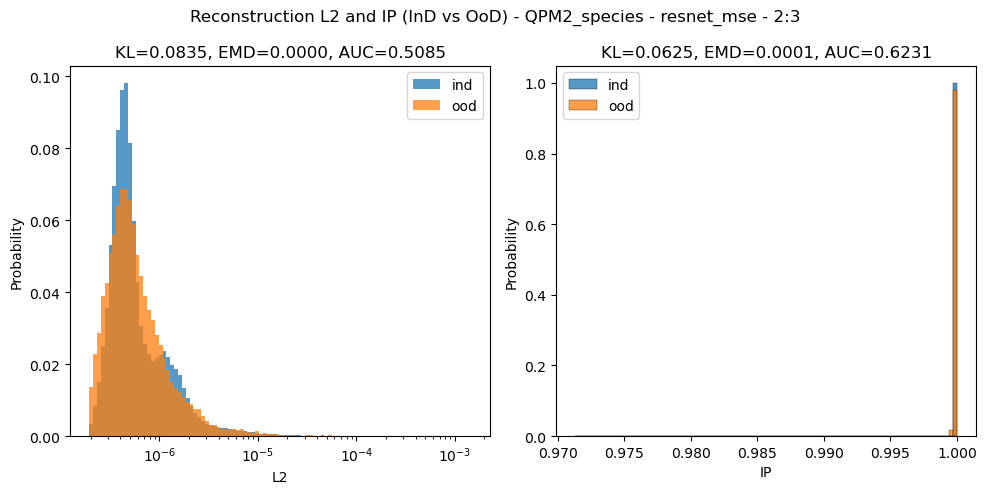

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)